# 160. Keras 내장 사전 훈련 모델을 이용한 Transfer Learning 

- ResNet50 pre-trained model 사용

- 1000 개의 class 분류 모델인 ResNet50 을 binary classifier (cat, dog) 으로 변형

- google colab 사용  

- My Drive 에 training data upload

# STEP #1: IMPORT LIBRARIES

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

# STEP #2: IMPORT MODEL WITH PRE-TRAINED WEIGHTS

In [ ]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')

# STEP #3: EVALUATE THE PRE-TRAINED MODEL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**tf.keras.preprocessing.image.load_img** - image 를 PIL (Python Image Library) format 으로 load

In [ ]:
Sample_Image= tf.keras.preprocessing.image.load_img('/content/drive/My Drive/Transfer Learning Data/train/cats/cat.1.jpg', 
                                                    target_size = (224, 224))

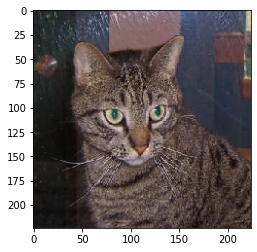

In [ ]:
plt.imshow(Sample_Image)

**tf.keras.preprocessing.image.img_to_array** - PIL image 를 numpy array 로 변경

In [ ]:
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)

In [ ]:
np.shape(Sample_Image)

(224, 224, 3)

In [ ]:
Sample_Image = np.expand_dims(Sample_Image, axis = 0)
np.shape(Sample_Image)

(1, 224, 224, 3)

### ResNet50 의 입력 spec 에 맞도록 Sample_Image preprocessing

In [ ]:
Sample_Image = tf.keras.applications.resnet50.preprocess_input(Sample_Image)

In [ ]:
predictions = model.predict(Sample_Image)
print(predictions.shape)
print(predictions[0,:10])

(1, 1000)
[3.2660562e-06 1.9151510e-06 5.0984482e-07 7.1587415e-06 2.6283324e-06
 9.8125083e-06 6.1672051e-07 1.3496028e-06 2.0055056e-06 4.6504050e-07]


### 확률 분포로 반환된 prediction 을 category name 으로 decode

In [ ]:
print('predictions:', tf.keras.applications.resnet50.decode_predictions(predictions, top = 5)[0])

predictions: [('n02123045', 'tabby', 0.7103849), ('n02123159', 'tiger_cat', 0.17781757), ('n02124075', 'Egyptian_cat', 0.06622933), ('n02127052', 'lynx', 0.00639383), ('n03958227', 'plastic_bag', 0.003955264)]


### ImageDataGenerator 이용

In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    preprocessing_function= tf.keras.applications.resnet50.preprocess_input)

train_generator = image_datagen.flow_from_directory('/content/drive/My Drive/Transfer Learning Data/train', 
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 202 images belonging to 2 classes.


# STEP #4: TRANSFER LEARNING 적용 및 model RETRAIN 

- ResNet50 의 top layer 제거 (include_top = False)
- GlobalAaveragePooling2D + Dense() layer 5 개 추가
    - global_average_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
    - prediction_layer = keras.layers.Dense(units=2, activation='softmax')(global_average_layer)

In [ ]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
for layer in base_model.layers[-5:]:
    print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


### base model 의 마지막에 5 개 layer 추가

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
preds = tf.keras.layers.Dense(2, activation = 'softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [ ]:
for layer in model.layers[-10:]:
    print(layer.name)

conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
global_average_pooling2d_1
dense_5
dense_6
dense_7
dense_8
dense_9


### Fine tuning 하기 전에 새로이 add 한 layer 들을 1 차 training 하여 초기화

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = False

for layer in model.layers[-5:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit_generator(generator = train_generator,  epochs = 5)

Epoch 1/5
7/7 [==============================] - 1s 195ms/step - loss: 0.7250 - accuracy: 0.7822
Epoch 2/5
7/7 [==============================] - 2s 215ms/step - loss: 0.0921 - accuracy: 0.9802
Epoch 3/5
7/7 [==============================] - 1s 194ms/step - loss: 0.0334 - accuracy: 0.9901
Epoch 4/5
7/7 [==============================] - 2s 214ms/step - loss: 0.0087 - accuracy: 0.9950
Epoch 5/5
7/7 [==============================] - 1s 194ms/step - loss: 3.0776e-04 - accuracy: 1.0000


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### 마지막 50 개 layer 만 fine tuning

In [ ]:
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
for layer in model.layers[-50:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

- steps_per_epoch : Total number of steps (batches of samples) to yield from generator

In [ ]:
history = model.fit_generator(generator = train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs = 10)

Epoch 1/10
6/6 [==============================] - 2s 252ms/step - loss: 0.8960 - accuracy: 0.8706
Epoch 2/10
6/6 [==============================] - 2s 282ms/step - loss: 0.1375 - accuracy: 0.9294
Epoch 3/10
6/6 [==============================] - 2s 253ms/step - loss: 0.0547 - accuracy: 0.9824
Epoch 4/10
6/6 [==============================] - 2s 272ms/step - loss: 0.0235 - accuracy: 0.9948
Epoch 5/10
6/6 [==============================] - 2s 282ms/step - loss: 7.0009e-04 - accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 2s 252ms/step - loss: 3.8158e-04 - accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 250ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 8/10
6/6 [==============================] - 2s 271ms/step - loss: 4.1436e-05 - accuracy: 1.0000
Epoch 9/10
6/6 [==============================] - 1s 248ms/step - loss: 3.3156e-06 - accuracy: 1.0000
Epoch 10/10
6/6 [==============================] - 2s 271ms/step - loss: 0.0549 - accuracy: 0.9948


# STEP #5: EVALUATE THE MODEL

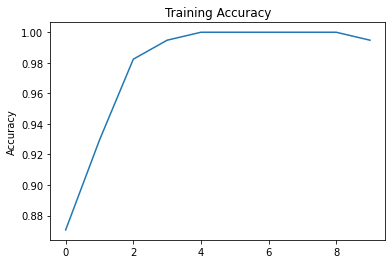

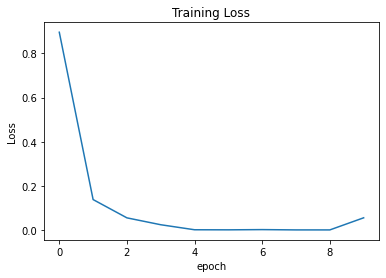

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from PIL import Image
from urllib import request
from io import BytesIO

url = "https://images.mypetlife.co.kr/content/uploads/2019/07/12153720/cat-4265304_1920.jpg"

res = request.urlopen(url).read()
img = Image.open(BytesIO(res))

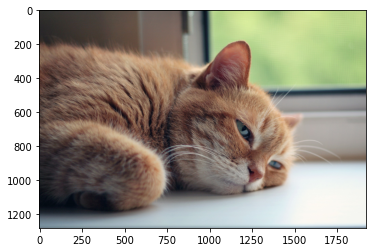

In [ ]:
plt.imshow(img)

In [ ]:
Sample_Image = tf.keras.preprocessing.image.img_to_array(img)
np.shape(Sample_Image)

(1279, 1920, 3)

In [ ]:
Sample_Image = np.expand_dims(Sample_Image, axis = 0)


In [ ]:
Sample_Image = tf.keras.applications.resnet50.preprocess_input(Sample_Image)
predictions = model.predict(Sample_Image)
print('Predictions:', predictions)

Predictions: [[1. 0.]]
